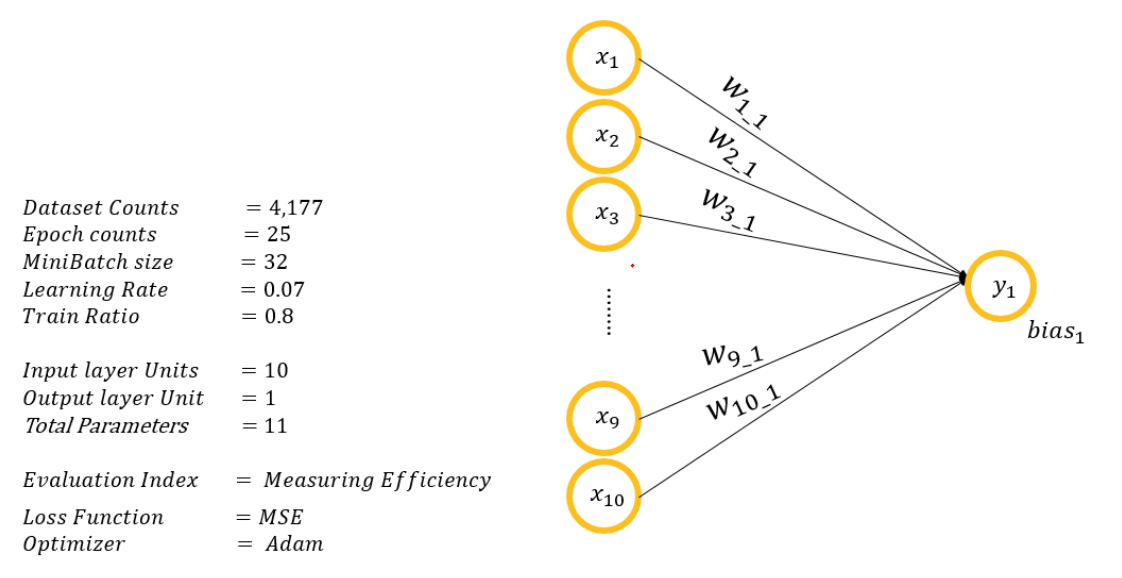

In [1]:
%run /content/CopyMathUtilis.ipynb


In [2]:
import pandas as pd 

In [3]:
df = pd.read_csv('/content/abalone.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
#전체 함수 실행 메인 문 작성 
def main_execute(epoch_count = 10 , mb_size = 2 , report = 2, train_ratio = 0.8):
  load_dataset() #데이터의 1항이 str 이기때문에 종류 별로 one_hot_vector 실행 
  weight_initial , bias_initial = init_param() #초기 weight 와 bias 를 parameter 초기화 함수에 저장 
  losses_mean_row , acces_mean_row ,final_acc = train_and_test(epoch_count,
                                                               mb_size,
                                                               report,
                                                               train_ratio)
  return weight_initial,bias_initial ,losses_mean_row , acces_mean_row,final_acc


In [5]:
def load_dataset():
  with open('/content/abalone.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    rows = []

    for row in csvreader:
      rows.append(row) #abalone data 읽기 

    global data , input_cnt ,output_cnt
    input_cnt , output_cnt  = 10 ,1
    data = np.zeros([len(rows),input_cnt + output_cnt])
 
    for n,row in enumerate(rows): #one_hot_vector 초기화 
      if row[0] == 'M': data[n,0] =1
      if row[1] == 'W': data[n,1] = 1
      if row[2] == 'I': data[n,2] = 1
      data[n,3:] = row[1:]


In [6]:
load_dataset()
data
data.shape

(4177, 11)

In [7]:
def init_param():
  global weight,bias

  weight_initial = []
  bias_initial = []
  weight = np.random.normal(RND_MEAN,RND_STD,size = [input_cnt,output_cnt])
  bias = np.zeros([output_cnt])


  weight_initial.append(weight)
  bias_initial.append(bias)

  return weight_initial,bias_initial

In [8]:
weight_initial , bias_initial = init_param()

In [9]:
def arrange_data(mb_size , train_ratio):
  global shuffle_map , test_begin_index

  shuffle_map = np.arange(data.shape[0])
  np.random.shuffle(shuffle_map)

  mini_batch_step_count = int(data.shape[0] * train_ratio) // mb_size #10 * 0.8 = 8 // 2 = 4 
  test_begin_index = mini_batch_step_count * mb_size # 4 *2 = 8
  return mini_batch_step_count

In [10]:
arrange_data(2,0.8)

1670

In [11]:
def get_test_data(): #test _data 가져오기
  test_data = data[shuffle_map[test_begin_index:]]
  return test_data[:,:-output_cnt] , test_data[:,-output_cnt:]

In [12]:
test_x,test_y = get_test_data()

In [13]:
def get_train_data(mb_size,n): #train_data 가져오기 
  if n == 0:
    np.random.shuffle(shuffle_map[:test_begin_index])
  
  train_data = data[shuffle_map[mb_size * n:mb_size * (n+1)]]

  return train_data[:,:-output_cnt], train_data[:,-output_cnt:]

In [14]:
train_x,train_y = get_train_data(2,0)

In [15]:
def forward_neuralnet(x): #y_hat 값 계산
  y_hat = np.matmul(x,weight) + bias
  return y_hat,x

In [16]:
y_hat,_ =forward_neuralnet(train_x)

In [17]:
def forward_postproc(y_hat,y): #loss 값 계산 
  diff = y_hat - y
  square = np.square(diff)
  loss  = np.mean(square)

  return loss,diff

 



In [18]:
loss,diff = forward_postproc(y_hat,train_y)

In [19]:
def eval_accuracy(y_hat,y):
  mdiff = np.mean(np.abs((y_hat - y)/y))
  return 1 - mdiff

In [20]:
acc = eval_accuracy(y_hat,train_y)
print(acc)

0.0015058007436363763


In [21]:
def backprop_neuralnet(G_output,x): #경사 하강법 계산
  global weight,bias

  x_transepose = x.transpose()
  G_w = np.matmul(x_transepose , G_output) #갱신된 W 의 값 을 함수로 호출해 저장
  G_b = np.sum(G_output,axis = 0) #갱신된 bias 의 값 이때 bias 는 loss 값에 대한 y 미분은 G 

  weight -= LEARNING_RATE * G_w
  bias -= LEARNING_RATE * G_b




In [22]:
def backprop_postproc(diff):
  M_N = diff.shape

  g_mse_square = np.ones(M_N) / np.prod(M_N) #np.prod = shape 행과 열의 곱을 하는 과정이다 
  g_square_diff = 2 * diff 
  g_diff_output = 1

  G_diff = g_mse_square * g_square_diff
  G_output = G_diff * g_diff_output

  return G_output

In [23]:
def run_train(x,y):
  y_hat,aux_nn_x = forward_neuralnet(x) #y_hay 값 그리고 x 값 
  loss,aux_pp_diff = forward_postproc(y_hat,y) #loss 값 계산 + 편차 값 까지 한번에 계산

  accuracy = eval_accuracy(y_hat,y) #정확도 계산 

  G_output = backprop_postproc(aux_pp_diff) #loss 값에 대한 경사 하강법 미분계산 
  backprop_neuralnet(G_output,aux_nn_x)

  return loss , accuracy
  

In [24]:
loss,accuracy = run_train(train_x,train_y)
loss,accuracy

(184.43561595518798, 0.0015058007436363763)

In [25]:
def run_test(x,y):
  y_hat,_ = forward_neuralnet(x)
  accuracy = eval_accuracy(y_hat,y)

  return accuracy

In [26]:
acc = run_test(test_x,test_y)
acc

0.5188930917766914

In [27]:
def train_and_test(epoch_count, mb_size, report, train_ratio):
    mini_batch_step_count = arrange_data(mb_size, train_ratio)
    test_x, test_y = get_test_data()

    losses_mean_row = []
    accs_mean_row   = []

    for epoch in range(epoch_count):
        losses = []
        accs   = [] 
        for n in range(mini_batch_step_count):
            train_x, train_y = get_train_data(mb_size, n)
            loss, acc= run_train(train_x, train_y)
            losses.append(loss)
            accs.append(acc)

        if report > 0 and (epoch + 1) % report == 0:
            acc = run_test(test_x, test_y)
            print("Epoch {} : Train - Loss = {:.3f}, Accuracy = {:.3f}  / Test - Accuracy = {:.3f}".\
                  format(epoch + 1, np.mean(losses), np.mean(accs), acc))
            
        losses_mean = np.mean(losses)
        accs_mean   = np.mean(accs) * 100

        losses_mean_row.append(losses_mean)
        accs_mean_row.append(accs_mean)

    final_acc = run_test(test_x, test_y)        
    print("=" * 35, "Final TEST", "=" * 35)
    print("\nFinal Accuracy : {:.3f}".format(final_acc))

    return losses_mean_row, accs_mean_row, final_acc

In [28]:
weight_initial, bias_initial, losses_mean_row, accs_mean_row, final_acc = main_execute(epoch_count = 1000,
                                                                                       mb_size = 36, 
                                                                                       report = 10, 
                                                                                       train_ratio = 0.8)

Epoch 10 : Train - Loss = 5.811, Accuracy = 0.821  / Test - Accuracy = 0.827
Epoch 20 : Train - Loss = 5.259, Accuracy = 0.831  / Test - Accuracy = 0.821
Epoch 30 : Train - Loss = 5.039, Accuracy = 0.835  / Test - Accuracy = 0.834
Epoch 40 : Train - Loss = 4.939, Accuracy = 0.838  / Test - Accuracy = 0.830
Epoch 50 : Train - Loss = 4.937, Accuracy = 0.837  / Test - Accuracy = 0.833
Epoch 60 : Train - Loss = 4.903, Accuracy = 0.838  / Test - Accuracy = 0.832
Epoch 70 : Train - Loss = 4.882, Accuracy = 0.839  / Test - Accuracy = 0.829
Epoch 80 : Train - Loss = 4.879, Accuracy = 0.839  / Test - Accuracy = 0.828
Epoch 90 : Train - Loss = 4.889, Accuracy = 0.838  / Test - Accuracy = 0.833
Epoch 100 : Train - Loss = 4.878, Accuracy = 0.838  / Test - Accuracy = 0.837
Epoch 110 : Train - Loss = 4.856, Accuracy = 0.838  / Test - Accuracy = 0.836
Epoch 120 : Train - Loss = 4.870, Accuracy = 0.839  / Test - Accuracy = 0.832
Epoch 130 : Train - Loss = 4.831, Accuracy = 0.839  / Test - Accuracy = 0

In [29]:
print("weight: ",weight)
print("bias: ",bias)

weight:  [[  0.446523  ]
 [ -0.0324511 ]
 [ -0.04711798]
 [ -1.41975644]
 [ 11.00495541]
 [ 20.59716717]
 [  9.33738218]
 [-20.1443697 ]
 [ -9.91315856]
 [  7.50090969]]
bias:  [2.78854939]


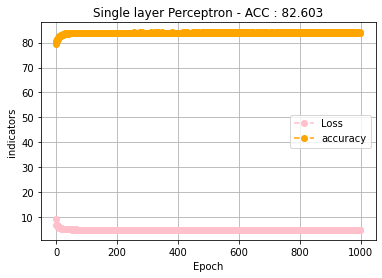

In [31]:
#정확도 와 loss 값 초기화 
import matplotlib.pyplot as plt

plt.plot(losses_mean_row , '--o',color = 'pink',label = 'Loss')
plt.plot(accs_mean_row , '--o',color = 'orange',label = 'accuracy')
plt.title("Single layer Perceptron - ACC : {:.3f}" .format(final_acc * 100))

plt.legend()
plt.grid()

plt.xlabel('Epoch')
plt.ylabel('indicators')

plt.show()